# Тестовое задание
## A/B–тестирование

В ходе тестирования целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
# импорт нужных библиотек
import pandas as pd
import requests
import scipy.stats as ss

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from urllib.parse import urlencode
from io import BytesIO


# настройки для отображения графиков
sns.set(font_scale=2, style="whitegrid",rc={'figure.figsize':(20,7)})

In [2]:
def get_data(public_key):
    # формирую URL для запроса к cloud-api.yandex.net
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=public_key))
    # из ответа cloud-api.yandex.net формирую URL для загрузки файла
    response = requests.get(final_url)
    download_url = response.json()['href']
    # получаю содержимое файла
    download_response = requests.get(download_url)
    return BytesIO(download_response.content)

In [3]:
# считываю файлы
groups       = pd.read_csv(get_data('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')
groups_add   = pd.read_csv(get_data('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))
active_studs = pd.read_csv(get_data('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))
checks       = pd.read_csv(get_data('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')

## Предобработка данных

In [4]:
groups.info() # файл с пользователями

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
groups_add.info() # дополнительный файл присланный через 2 дня

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [6]:
# объединяю данные в один дата фрейм
ab_test_data = pd.concat([groups, groups_add], ignore_index=True)
ab_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74576 non-null  int64 
 1   grp     74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [7]:
# с помощью множеств проверяю, нет ли пересечения между группами пользователей
gr_a = set(ab_test_data.query("grp=='A'").id)
gr_b = set(ab_test_data.query("grp=='B'").id)

gr_a.intersection(gr_b)

set()

In [8]:
# отфильтровываю пользователей, которые были активны в дни проведения эксперимента
ab_test_data = ab_test_data[ab_test_data.id.isin(active_studs.student_id)].reset_index(drop=True)
ab_test_data.tail()

,id,grp
8336,5760471,B
8337,5777081,B
8338,5870856,A
8339,5945085,B
8340,5951797,B


In [9]:
# подтягию поле с информацией об оплатах пользователей
# делаю именно left merge, чтобы также отобразить активных пользователей не совершивших оплату
ab_test_data_ = ab_test_data.merge(checks, how='left', left_on='id', right_on='student_id').drop(columns='student_id')
ab_test_data_

,id,grp,rev
0,1627,A,990.0
1,2085,B,NaN
2,2215,B,NaN
3,3391,A,NaN
4,3401,B,NaN
...,...,...,...
8336,5760471,B,NaN
8337,5777081,B,NaN
8338,5870856,A,NaN
8339,5945085,B,NaN


## Выбор метрик и стастические тесты
Для сравнения контрольной и целевой групп проверю, как изменились метрики:
* **Конверсия активности пользователя в покупку** (не учитываю пользователей, которые не заходили на платформу в дни проведения эксперимента, но по которым всё равно прошла оплата. Считаю это за автоматические списания, в которых пользователи не взаимодействовали с механикой оплаты услуг на сайте, а следовательно — такие пользователи не являются частью исследования)
* **Средний доход с платящего пользователя (ARPPU)**

### Конверсия в покупку

In [10]:
# создаю поле с булевым значением, показывающим сконвертировался ли активный пользователь в покупку
ab_test_data_['converted'] = ab_test_data_.rev.notna()
ab_test_data_.head()

,id,grp,rev,converted
0,1627,A,990.0,True
1,2085,B,NaN,False
2,2215,B,NaN,False
3,3391,A,NaN,False
4,3401,B,NaN,False


In [11]:
ab_test_data_.groupby('grp').converted.mean()

grp
A    0.050715
B    0.046156
Name: converted, dtype: float64

**Конверсия в целевой группе стала меньше!**

#### Гипотезы

Теперь проверю являются ли различия в конверсиях статистически значимыми. Для этого c помощью T-теста сравню средние значения по полю **converted** в группах. Cреднее этих булевых значений и является значением конверсии:
* **Нулевая гипотеза (H0)** — средние значения по полю converted между группами не различаются  
* **Альтернативная гипотеза (H1)** — средние значения по полю converted различаются

In [12]:
group_sizes = ab_test_data_.grp.value_counts() # количество наблюдений в группах
group_sizes

grp
B    6803
A    1538
Name: count, dtype: int64

In [13]:
ab_test_data_.duplicated('id').sum() # для каждого пользователя в данных только одна запись — наблюдения независимы

0

In [14]:
# применяю тест Левена для проверки гомогенности дисперсий
statistic, p_value = ss.levene(ab_test_data_.query("grp == 'A'").converted, ab_test_data_.query("grp == 'B'").converted)
if p_value > 0.05:
    print('Дисперсии внутри двух групп примерно одинаковы')
else:
    print('Дисперсии внутри двух групп различаются')

Дисперсии внутри двух групп примерно одинаковы


In [15]:
# применяю ttest
ss.ttest_ind(ab_test_data_.query("grp == 'A'").converted, ab_test_data_.query("grp == 'B'").converted)

Ttest_indResult(statistic=0.7629235937766906, pvalue=0.445530545137386)

Значение p-value значительно выше стандартного порога значимости в 0.05, что не даёт возможность отклонить нулевую гипотезу и принять альтернативную — **значения конверсий в двух группах статистически значимо не различаются**

### Метрика ARPPU 

In [16]:
# количество пользователей по группам, которые произвели оплату
ab_test_data_.dropna().groupby('grp').size()

grp
A     78
B    314
dtype: int64

**Метрика ARPPU увеличилась в целевой группе!**

In [17]:
ab_test_data_.groupby('grp').rev.mean()

grp
A     933.589744
B    1257.878992
Name: rev, dtype: float64

**Медианная выручка на пользователя тоже увеличилась!**

In [18]:
ab_test_data_.groupby('grp').rev.median()

grp
A     585.0
B    1140.0
Name: rev, dtype: float64

**Даже метрика ARPU также стала выше в целевой группе!**

In [19]:
ab_test_data_.fillna(0).groupby('grp').rev.mean()

grp
A    47.347204
B    58.058798
Name: rev, dtype: float64

<Axes: xlabel='rev', ylabel='Count'>

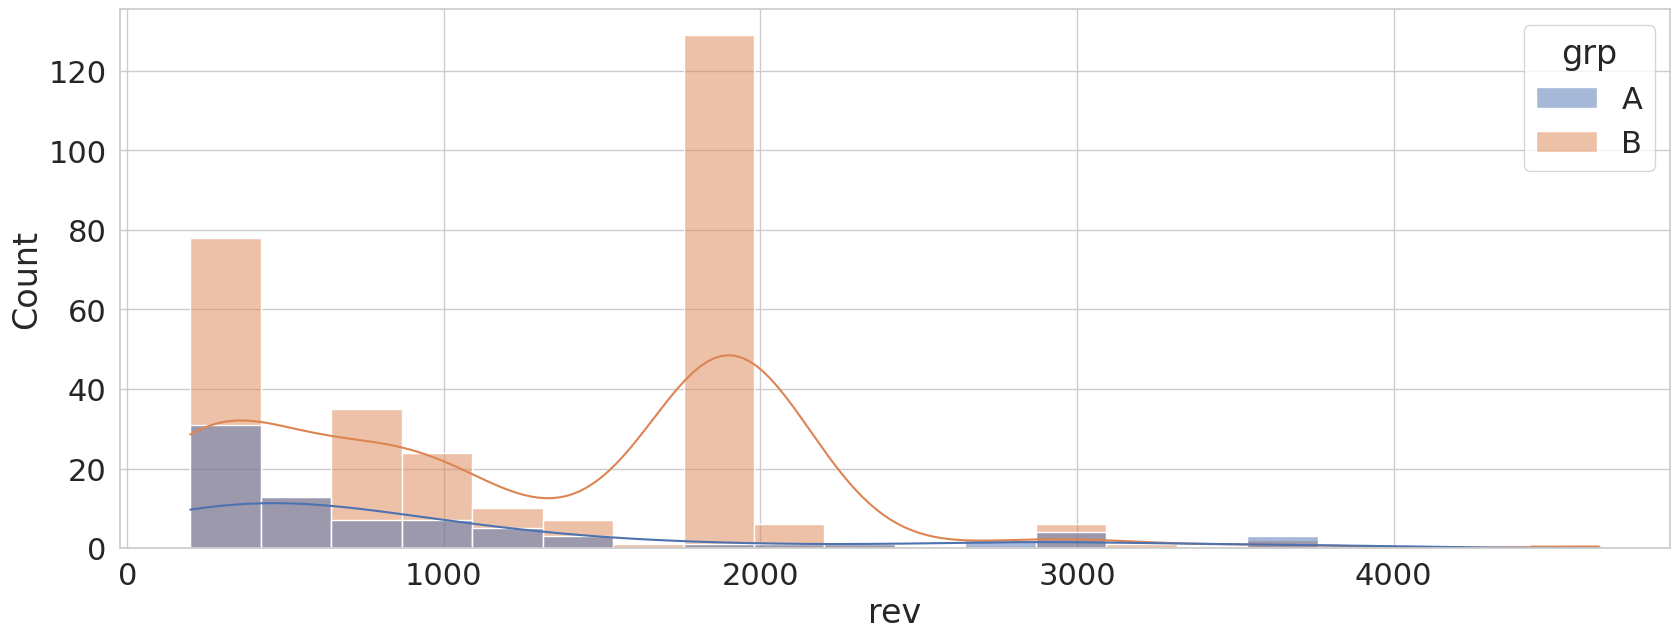

In [20]:
# проверяю распределения чеков в группах
sns.histplot(data=ab_test_data_, x="rev", hue="grp", kde=True, bins=20)

По графику видно, что большое количество оплат в целевой группе было произведенно на сумму от **1800 до 2000 рублей**. Проверю процент таких чеков в общем количестве чеков по группам

In [21]:
# создаю Series с количество таких чеков по группам
data = {'A': ab_test_data_.query("grp == 'A' & rev >= 1800 & rev <= 2000").shape[0],
        'B': ab_test_data_.query("grp == 'B' & rev >= 1800 & rev <= 2000").shape[0]}
series = pd.Series(data)
series

A      2
B    131
dtype: int64

In [22]:
# процент чеков от 1800 до 2000 рублей в общем количестве чеков по группам. В целевой группе таких 41%!
series / ab_test_data_.dropna().groupby('grp').size()

A    0.025641
B    0.417197
dtype: float64

#### Сравнение групп на графиках

<Axes: xlabel='grp', ylabel='rev'>

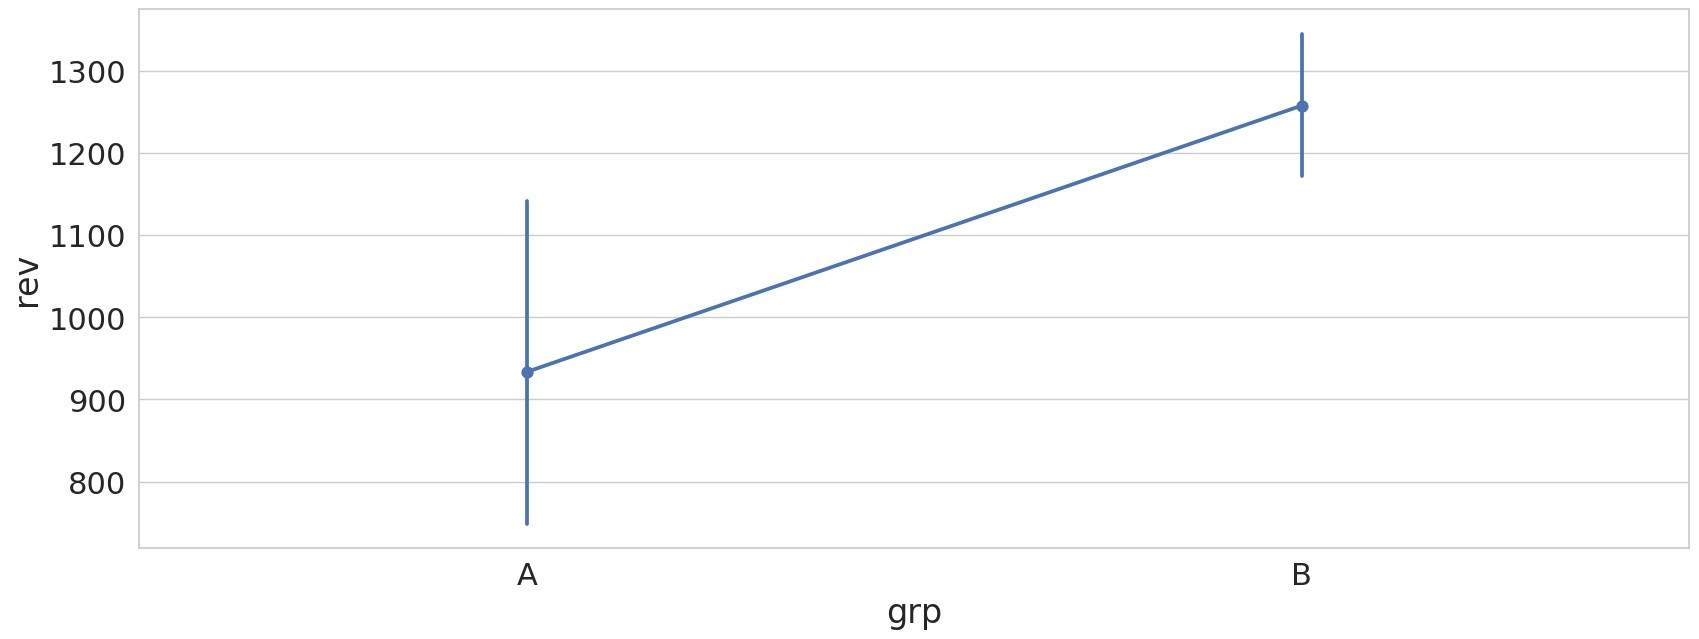

In [23]:
sns.pointplot(x='grp', y='rev', data=ab_test_data_.dropna(), ci=95) # доверительные интервалы по группам

<Axes: xlabel='grp', ylabel='rev'>

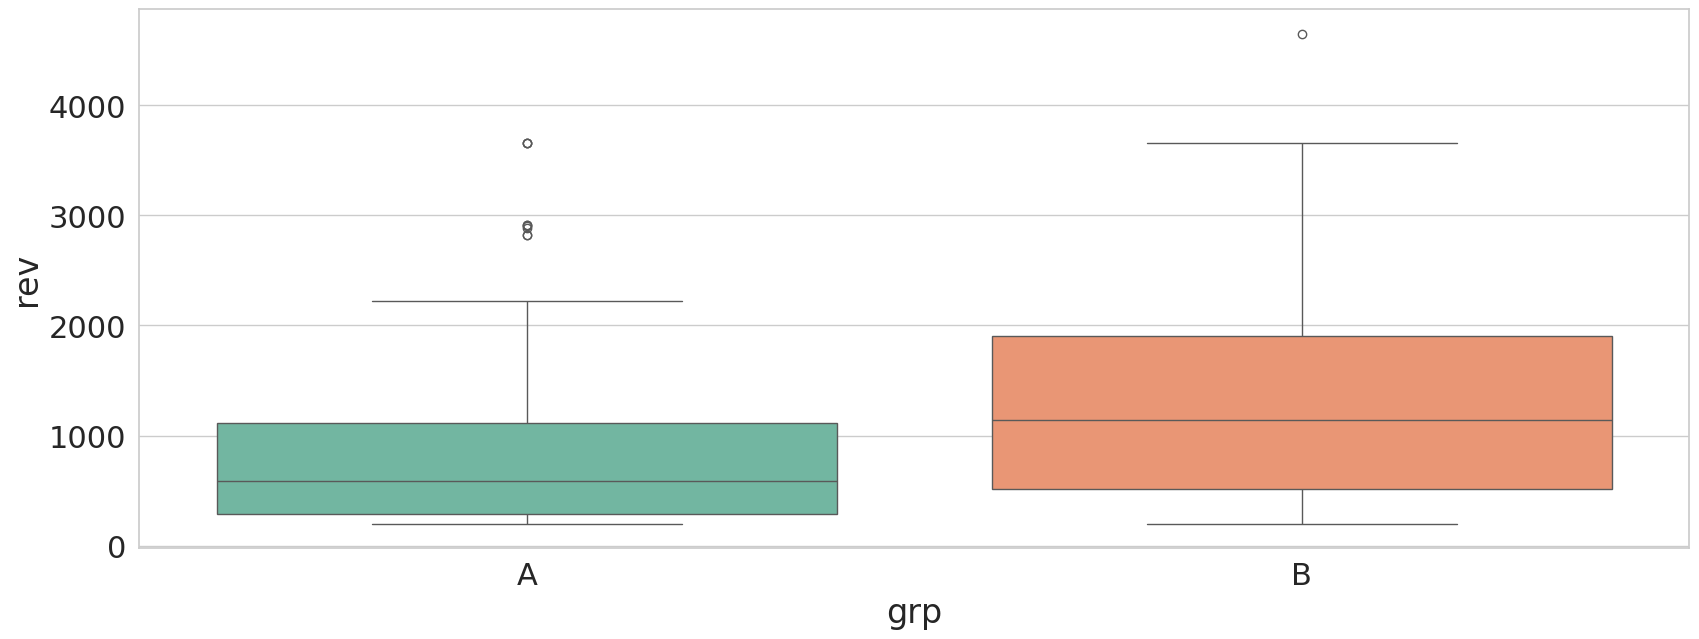

In [24]:
sns.boxplot(x='grp', y='rev', data=ab_test_data_.dropna(), palette='Set2') # графики боксплот по группам

По графикам доверительных интервалов и боксплот видна разница между группами. Теперь нужно подтвердить статистическую значимость этих различий. Так как распределения в группах далеки от нормального, то вместо T-test воспользусь методом **bootstrap**

#### Реализация bootstrap

Сформулирую гипотезы:
* **Нулевая гипотеза (H0)** — средние значения дохода с платящего пользователя (метрика ARPPU) в двух группах **не различаются**
* **Альтернативная гипотеза (H1)** — средние значения дохода с платящего пользователя в двух группах **различаются**

In [25]:
# наблюдаемая разница между средними значениями двух групп
group_A_paying_users = ab_test_data_.query("grp == 'A'").rev.dropna()
group_B_paying_users = ab_test_data_.query("grp == 'B'").rev.dropna()

abs(group_A_paying_users.mean() - group_B_paying_users.mean())

324.2892484484729

In [26]:
# задаю количество повторных выборок
n_bootstrap = 10000

# генерирую бутстрап выборки, разницу средних значений между группами записываю в массив
mean_diffs = []
for _ in range(n_bootstrap):
    bootstrap_group_A = group_A_paying_users.sample(frac=1, replace=True)
    bootstrap_group_B = group_B_paying_users.sample(frac=1, replace=True)
    mean_diff = abs(bootstrap_group_A.mean() - bootstrap_group_B.mean())
    mean_diffs.append(mean_diff)

<Axes: ylabel='Count'>

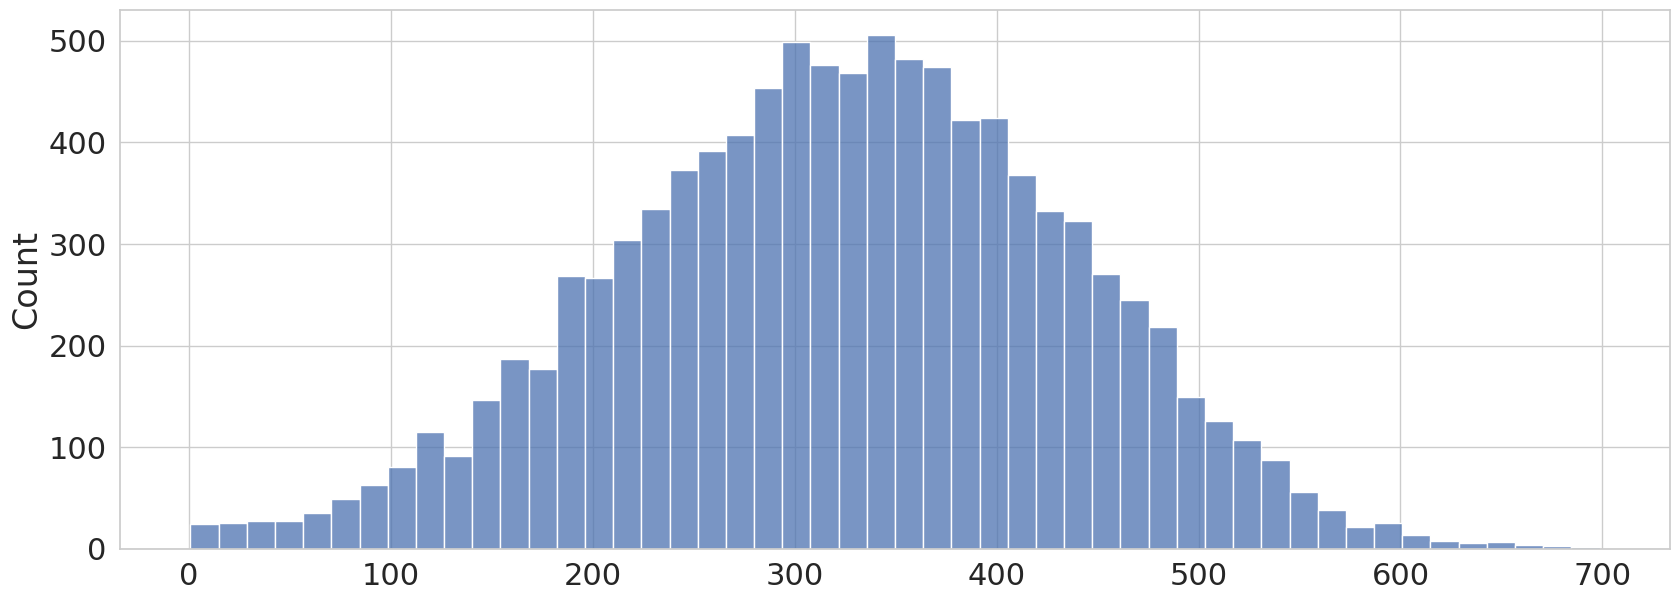

In [27]:
sns.histplot(mean_diffs) # распределение разницы средних из бутстрап выборок

In [28]:
# верхняя граница доверительного интервала
pd.Series(mean_diffs).quantile(0.975)

534.3104477566144

In [29]:
# нижняя граница доверительного интервала
pd.Series(mean_diffs).quantile(0.025)

98.38223361852833

Ноль даже близко не попадает в границы доверительного интервала разницы средних значений, следовательно можно **отвергнуть нулевую гипотезу и принять альтернативную о том, что средние значения двух групп различаются**. Метрика ARPPU статистически значимо увеличилась в целевой группе.

## Вывод

C помощью тестов было установлено, что в группе с новой механикой оплаты услуг метрика конверсии в покупку статистически значимо не изменилась, но средний доход с платящего пользователя существенно вырос за счёт увеличения среднего количества пользователей, закрывающих чеки от 1800 до 2000 рублей. Статистическая значимость прироста метрики ARPPU была подтверждена с помощью метода Bootstrap. **Основной вывод —  запуск на всех пользователей новой механики оплаты будет полезен для экономики продукта.**